In [ ]:
import os
import tqdm
import pickle
import pprint
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set the data and working folders

working_dir = "/content/drive/MyDrive/spwio"
data_path = os.path.join(working_dir, "data")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Economic modeling
In this section, we undertake input-output macro economic modeling using Leontief (for the upstream) and Ghosh (for the downstream) implicit impacts.
The direct shocks estimates from scenario modeling are applied as the final demand column vectors.
<br></br>
**Ghosh**
$$
x = v'(I - B)^{-1}
$$

**Leontief Formula**

$$
X = (I - A)^{-1}F
$$
where $(I - A)^{-1}$ is Leontief inverse


In [ ]:
# Read the BEA supply use data
technical_coefficients = pd.read_csv(os.path.join(data_path, "direct_requirements.csv")) # total requirements table

technical_coefficients.head(5)

technical_coefficients['Utilities'].sum()

0.36940340000000005

In [ ]:
# 2022 US gross output by industires, in million dollars
gross_output_2022 = pd.read_csv(os.path.join(data_path, "use_table.csv"))
gross_output_2022.set_index("Name", inplace=True)

# # Total by industry
y_output = gross_output_2022.loc["Total industry output (basic prices)"].to_numpy().T.astype(int) /1000 # y output

y_output

array([ 644.755,  830.937,  665.432, 2131.939, 7162.401, 2481.375,
       2404.055, 1771.549, 2406.922, 8268.954, 5338.993, 3380.27 ,
       1832.25 ,  871.147, 4936.725])

In [ ]:
# NAICS code and industry concordance
NAICSIndustries = {
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarrying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "48": "Transportation and Warehousing",
    "51": "Information",
    "FIRE": "Finance, insurance, real estate, rental, and leasing",
    "PROF": "Professional and business services",
    "6": "Educational services, health care, and social assistance",
    "7": "Arts, entertainment, recreation, accommodation, and food services",
    "81": "Other Services (except Public Administration)",
    "G": "Government",
}

In [ ]:
# Personal consumption data
consumption = pd.read_csv(os.path.join(data_path, "IOdata", "consumption.csv")).iloc[:, 2] / (365 * 1.2) # 2022 Personal Consumption per industry
consumption.head(5)

0    533.333333
1     29.420091
2      0.000000
3      0.739726
4      0.000000
Name: Consumption, dtype: float64

In [ ]:
# Leontief matrix calculation
A = technical_coefficients.to_numpy() # convert to numpy array
identity_matrix = np.eye(A.shape[0])

# Calculate the Leontief inverse matrix
L = np.linalg.inv(identity_matrix - A) # using stipulated formula in the introduction

gross_diag = np.diag(y_output) # Make the industrial output as the diagonal in a n by n matrix where n is number of industries/commodities
gross_diag_inv = np.linalg.inv(gross_diag) # Inverse of the diagonal matrix of outputs
B = np.dot(np.dot(gross_diag_inv, A), gross_diag) # Get the B coefficient matrix

# Ghosh model calculation
ghosh_model = np.linalg.inv(identity_matrix - B) # Ghosh model using formula articulated in the introduction

In [ ]:
# Load the US GDP by states data
us_gdp_sectors = pd.read_csv(os.path.join(data_path, "Us_gdp_sectors.csv"))
us_gdp_sectors.set_index("NAICS", inplace=True, drop=True)

# Create a sorting key based on NAICSIndustries keys
sort_key = {code: i for i, code in enumerate(NAICSIndustries.keys())}

# Sort us state data index based on the sort_key
us_gdp_sectors = us_gdp_sectors.loc[sorted(us_gdp_sectors.index, key=lambda x: sort_key.get(x, float('inf')))]

# Rename 92 to Government or other
us_gdp_sectors.rename(index={"92": 'G'}, inplace=True)

In [ ]:
us_gdp_sectors["CGDP2022"] = us_gdp_sectors["CGDP2022"]/1000 * 1.25
us_gdp_sectors["Industry"] = NAICSIndustries.values()
us_gdp_sectors.sort_values(by="CGDP2022", ascending=False)

,CGDP2022,Industry
NAICS,,
FIRE,5665.619625,"Finance, insurance, real estate, rental, and l..."
PROF,4022.026875,Professional and business services
G,2966.849000,Government
31,2842.930750,Manufacturing
6,2388.940125,"Educational services, health care, and social ..."
51,1877.062750,Information
44,1467.914375,Retail Trade
42,1428.936500,Wholesale Trade
7,1093.370750,"Arts, entertainment, recreation, accommodation..."


In [ ]:
# Test the Leontief Model with the GDP2022 Data

f_d = us_gdp_sectors["CGDP2022"].to_numpy()

L_test = L @ f_d

x_d = pd.DataFrame(L_test) # total output demand
x_d["NAICS"] = NAICSIndustries.keys()
x_d

,0,NAICS
0,698.834036,11
1,887.729587,21
2,741.372635,22
3,1107.445464,23
4,6257.988235,31
5,2165.462349,42
6,1316.808294,44
7,1646.514258,48
8,2301.265052,51
9,7979.942266,FIRE


In [ ]:
np.transpose(ghosh_model) @ f_d

array([ 455.22090049,  558.70491524,  518.13947586, 1662.73811129,
       6009.30038906, 2111.24841546, 2025.98234335, 1392.55455153,
       2472.38451311, 7056.24033172, 4987.69528203, 2992.89324904,
       1568.45671708,  680.78292829, 4109.26933666])

In [ ]:
y_output

array([ 644.755,  830.937,  665.432, 2131.939, 7162.401, 2481.375,
       2404.055, 1771.549, 2406.922, 8268.954, 5338.993, 3380.27 ,
       1832.25 ,  871.147, 4936.725])

In [ ]:
# Read grid data
df_grid = pd.read_csv(os.path.join(data_path, "grid_data.csv"))
# Set regions as the index
df_grid.set_index("REGIONS", inplace=True)
df_grid.head(5)

,EST,DailyGDP,ESTPerc,POP20,POP20Ratio,DailyGDPPerc
REGIONS,,,,,,
CAISO,930258.0,8.322560,0.116457,36669676,0.112628,0.140238
ERCOT,571392.0,4.735475,0.071532,25756383,0.079109,0.079794
FRCC,584768.0,3.196764,0.073206,20269759,0.062257,0.053867
ISONE,366368.0,2.912896,0.045865,14160438,0.043493,0.049083
MISO,1051459.0,7.118827,0.131630,44656227,0.137158,0.119955


In [ ]:
# Read the previously nested dictionary in scenario modeling
with open(os.path.join(data_path, "nested_dict.pkl"), 'rb') as file:
    nested_dict = pickle.load(file)

pprint.pprint(next(iter(nested_dict.items())))

('CAISO',
 {'NAICS': {'11': {'DAILYGDP': 0.07275126027397259,
                   'EST': 1254.0,
                   'ESTPerc': 0.000156985969535458},
            '21': {'DAILYGDP': 0.01755545205479452,
                   'EST': 257.0,
                   'ESTPerc': 3.217336058262576e-05},
            '22': {'DAILYGDP': 0.10103983561643835,
                   'EST': 552.0,
                   'ESTPerc': 6.910387175723509e-05},
            '23': {'DAILYGDP': 0.27387375342465753,
                   'EST': 75608.0,
                   'ESTPerc': 0.009465227419965637},
            '31': {'DAILYGDP': 0.9183521643835616,
                   'EST': 33696.0,
                   'ESTPerc': 0.004218340693354698},
            '42': {'DAILYGDP': 0.39279600000000003,
                   'EST': 53245.0,
                   'ESTPerc': 0.006665644296583301},
            '44': {'DAILYGDP': 0.4097550684931507,
                   'EST': 97324.0,
                   'ESTPerc': 0.012183813795110776},
            '48

In [ ]:
#  Read the direct shocks from the scenario modeling
with open(os.path.join(data_path, "scenarios.pkl"), 'rb') as file:
    scenario_percentile_dfs = pickle.load(file)

## Get the indirect shocks

In [ ]:
data_bounds = ["Mean", "1.96sd", "-1.96sd"]

# Grid Failures
grid_failures = [2, 4, 6, 8] # 3, 4, or 6 regions fail

In [ ]:
# Get the DailyGDP by NAICs, establishment count, and population of the simulated scenarios

def get_transformed_data(df, quantiles=data_bounds, nested_dict=nested_dict, df_index=df_grid) -> dict:
    """
    Transforms the input DataFrame and calculates various metrics for GDP and establishments.

    Parameters:
    df (DataFrame): The input DataFrame.
    quantiles (list): List of quantile values.
    nested_dict (dict): Nested dictionary containing NAICS data.
    df_index (DataFrame): DataFrame containing index data such as DailyGDP and POP20.

    Returns:
    dict: A dictionary containing grouped region and NAICS data, and population data.
    """
    # Transpose and rename columns
    percentiles_transformed = df.T
    percentiles_transformed.columns = quantiles
    percentiles_transformed.drop("GDPSum", inplace=True)

    # Initialize data lists
    new_rows_gdp, new_rows_est = [], []
    new_col_names = ["REGIONS", "NAICS"] + data_bounds

    # Process each region
    for reg, row in percentiles_transformed.iterrows():
        non_zero_indices = [i for i, value in enumerate(row) if value != 0]

        for naics, data in nested_dict[reg]["NAICS"].items():
            new_row_gdp = [reg, naics] + [data["DAILYGDP"] if i in non_zero_indices else 0 for i in range(len(row))]
            new_row_est = [reg, naics] + [data["EST"] if i in non_zero_indices else 0 for i in range(len(row))]

            new_rows_gdp.append(new_row_gdp)
            new_rows_est.append(new_row_est)

    # Create DataFrames
    df_gdp = pd.DataFrame(new_rows_gdp, columns=new_col_names)
    df_est = pd.DataFrame(new_rows_est, columns=new_col_names)

    # Group by regions and NAICS
    grouped_regions_est = df_est.groupby("REGIONS").sum(numeric_only=True)
    grouped_naics_est = df_est.groupby("NAICS").sum(numeric_only=True)
    df_gdp_naics = df_gdp.groupby("NAICS").sum(numeric_only=True)
    df_gdp_regions = df_gdp.groupby("REGIONS").sum(numeric_only=True)

    # Calculate percentages of daily output
    gdp_loss_est_df_perc = (df_gdp_naics / df_index.DailyGDP.sum()).round(2)

    # Establishments without power
    est_binary = grouped_regions_est.ne(0).astype(int)

    # Population without power
    pop_est_df = (est_binary.apply(lambda row: row * df_index.loc[row.name, "POP20"], axis=1) / 1000000).round(2)
    pop_est_df_perc = (pop_est_df / (df_index.POP20.sum()/1e6)).round(2)

    return {"regions_est": grouped_regions_est, "gdp_by_naics": df_gdp_naics, "gdp_by_regions": df_gdp_regions, "pop": pop_est_df }

In [ ]:
# Run Ghosh model to get indirect Downstream impacts
impact_dfs = []
percentile = 100
scenario_counter = 0  # Scenario counter

# Create a sorting key based on NAICSIndustries keys
sort_key = {code: i for i, code in enumerate(NAICSIndustries.keys())}

for i, scenario_df in tqdm.tqdm(enumerate(scenario_percentile_dfs)):
  extent = grid_failures[i]

  soc_econ_df = get_transformed_data(scenario_df)
  GDPShocks = soc_econ_df["gdp_by_naics"] # GDP by NAICS
  # Sort GDPShocks index based on the sort_key
  GDPShocks = GDPShocks.loc[sorted(GDPShocks.index, key=lambda x: sort_key.get(x, float('inf')))]

  pop_df = soc_econ_df["pop"] # popualtion within the affected regions
  for quantile_index, j in enumerate(data_bounds):
      scenario_counter += 1
      perc_column = data_bounds[quantile_index]
      pop = pop_df[perc_column].sum()

      VA = GDPShocks[j]

      VA = VA.to_numpy()

      # Apply Ghosh and Leontief models
      VAm = VA.reshape(1, -1)
      Lem = VA.reshape(-1, 1)
      output = (np.dot(VAm, ghosh_model) - VAm).flatten()

      leonoutput = np.dot(L, Lem) - Lem


      # Prepare 'direct_impact_df'
      direct_impact_df = GDPShocks.copy()
      direct_impact_df["NAICS"] = direct_impact_df.index
      direct_impact_df["NAICSIndustries"] = direct_impact_df["NAICS"].map(NAICSIndustries)

      # Create and concatenate data frames
      concat_df = pd.concat([
          pd.DataFrame({'Scenario': f's{scenario_counter}', 'Type': 'Downstream', "Count": extent, "Variable": perc_column, 'NAICSIndustries': NAICSIndustries.values(), 'Output': output}),
          direct_impact_df.assign(Output=direct_impact_df[perc_column], Variable=perc_column, Count=extent, Type='Direct', Scenario=f's{scenario_counter}')[['Scenario', 'Type', 'Variable', 'Count', 'NAICSIndustries', 'Output']]
      ], ignore_index=True)

      impact_dfs.append(concat_df)

# Concatenate all the scenario dataframes
impact_df = pd.concat(impact_dfs)
impact_df_reset = impact_df.groupby(["Scenario", "Type", "Count", "NAICSIndustries", "Variable"])["Output"].sum().reset_index()
impact_df_reset.head(5)

4it [00:00, 15.02it/s]


,Scenario,Type,Count,NAICSIndustries,Variable,Output
0,s1,Direct,2,"Agriculture, Forestry, Fishing and Hunting",Mean,0.039074
1,s1,Direct,2,"Arts, entertainment, recreation, accommodation...",Mean,0.388581
2,s1,Direct,2,Construction,Mean,0.291561
3,s1,Direct,2,"Educational services, health care, and social ...",Mean,0.732284
4,s1,Direct,2,"Finance, insurance, real estate, rental, and l...",Mean,2.304160


In [ ]:
# Pivot the DataFrame so that each 'Type' becomes a column
pivot_df = impact_df_reset.pivot_table(index=['Scenario', "Count", 'Variable', "NAICSIndustries"], columns='Type', values='Output', aggfunc='sum')

# Calculate the 'Total' column as the sum of 'Direct' and 'Supply' columns
pivot_df['Total'] = pivot_df.sum(axis=1)

# Reset the index to flatten the DataFrame after pivoting
pivot_df_reset = pivot_df.reset_index()

# Optionally, rename the columns to remove the multi-level column indexing
pivot_df_reset.columns.name = None  # Remove the categorization name
# pivot_df_reset.columns = ['Scenario', 'Variable', 'NAICSIndustries', 'Direct', 'Supply', 'Total']  # Explicitly name the columns

df = pivot_df_reset.copy()
df.head(5)

,Scenario,Count,Variable,NAICSIndustries,Direct,Downstream,Total
0,s1,2,Mean,"Agriculture, Forestry, Fishing and Hunting",0.039074,0.083849,0.122924
1,s1,2,Mean,"Arts, entertainment, recreation, accommodation...",0.388581,0.268626,0.657207
2,s1,2,Mean,Construction,0.291561,0.266432,0.557993
3,s1,2,Mean,"Educational services, health care, and social ...",0.732284,0.413067,1.145351
4,s1,2,Mean,"Finance, insurance, real estate, rental, and l...",2.304160,1.090829,3.394989


## Visualize the impacts

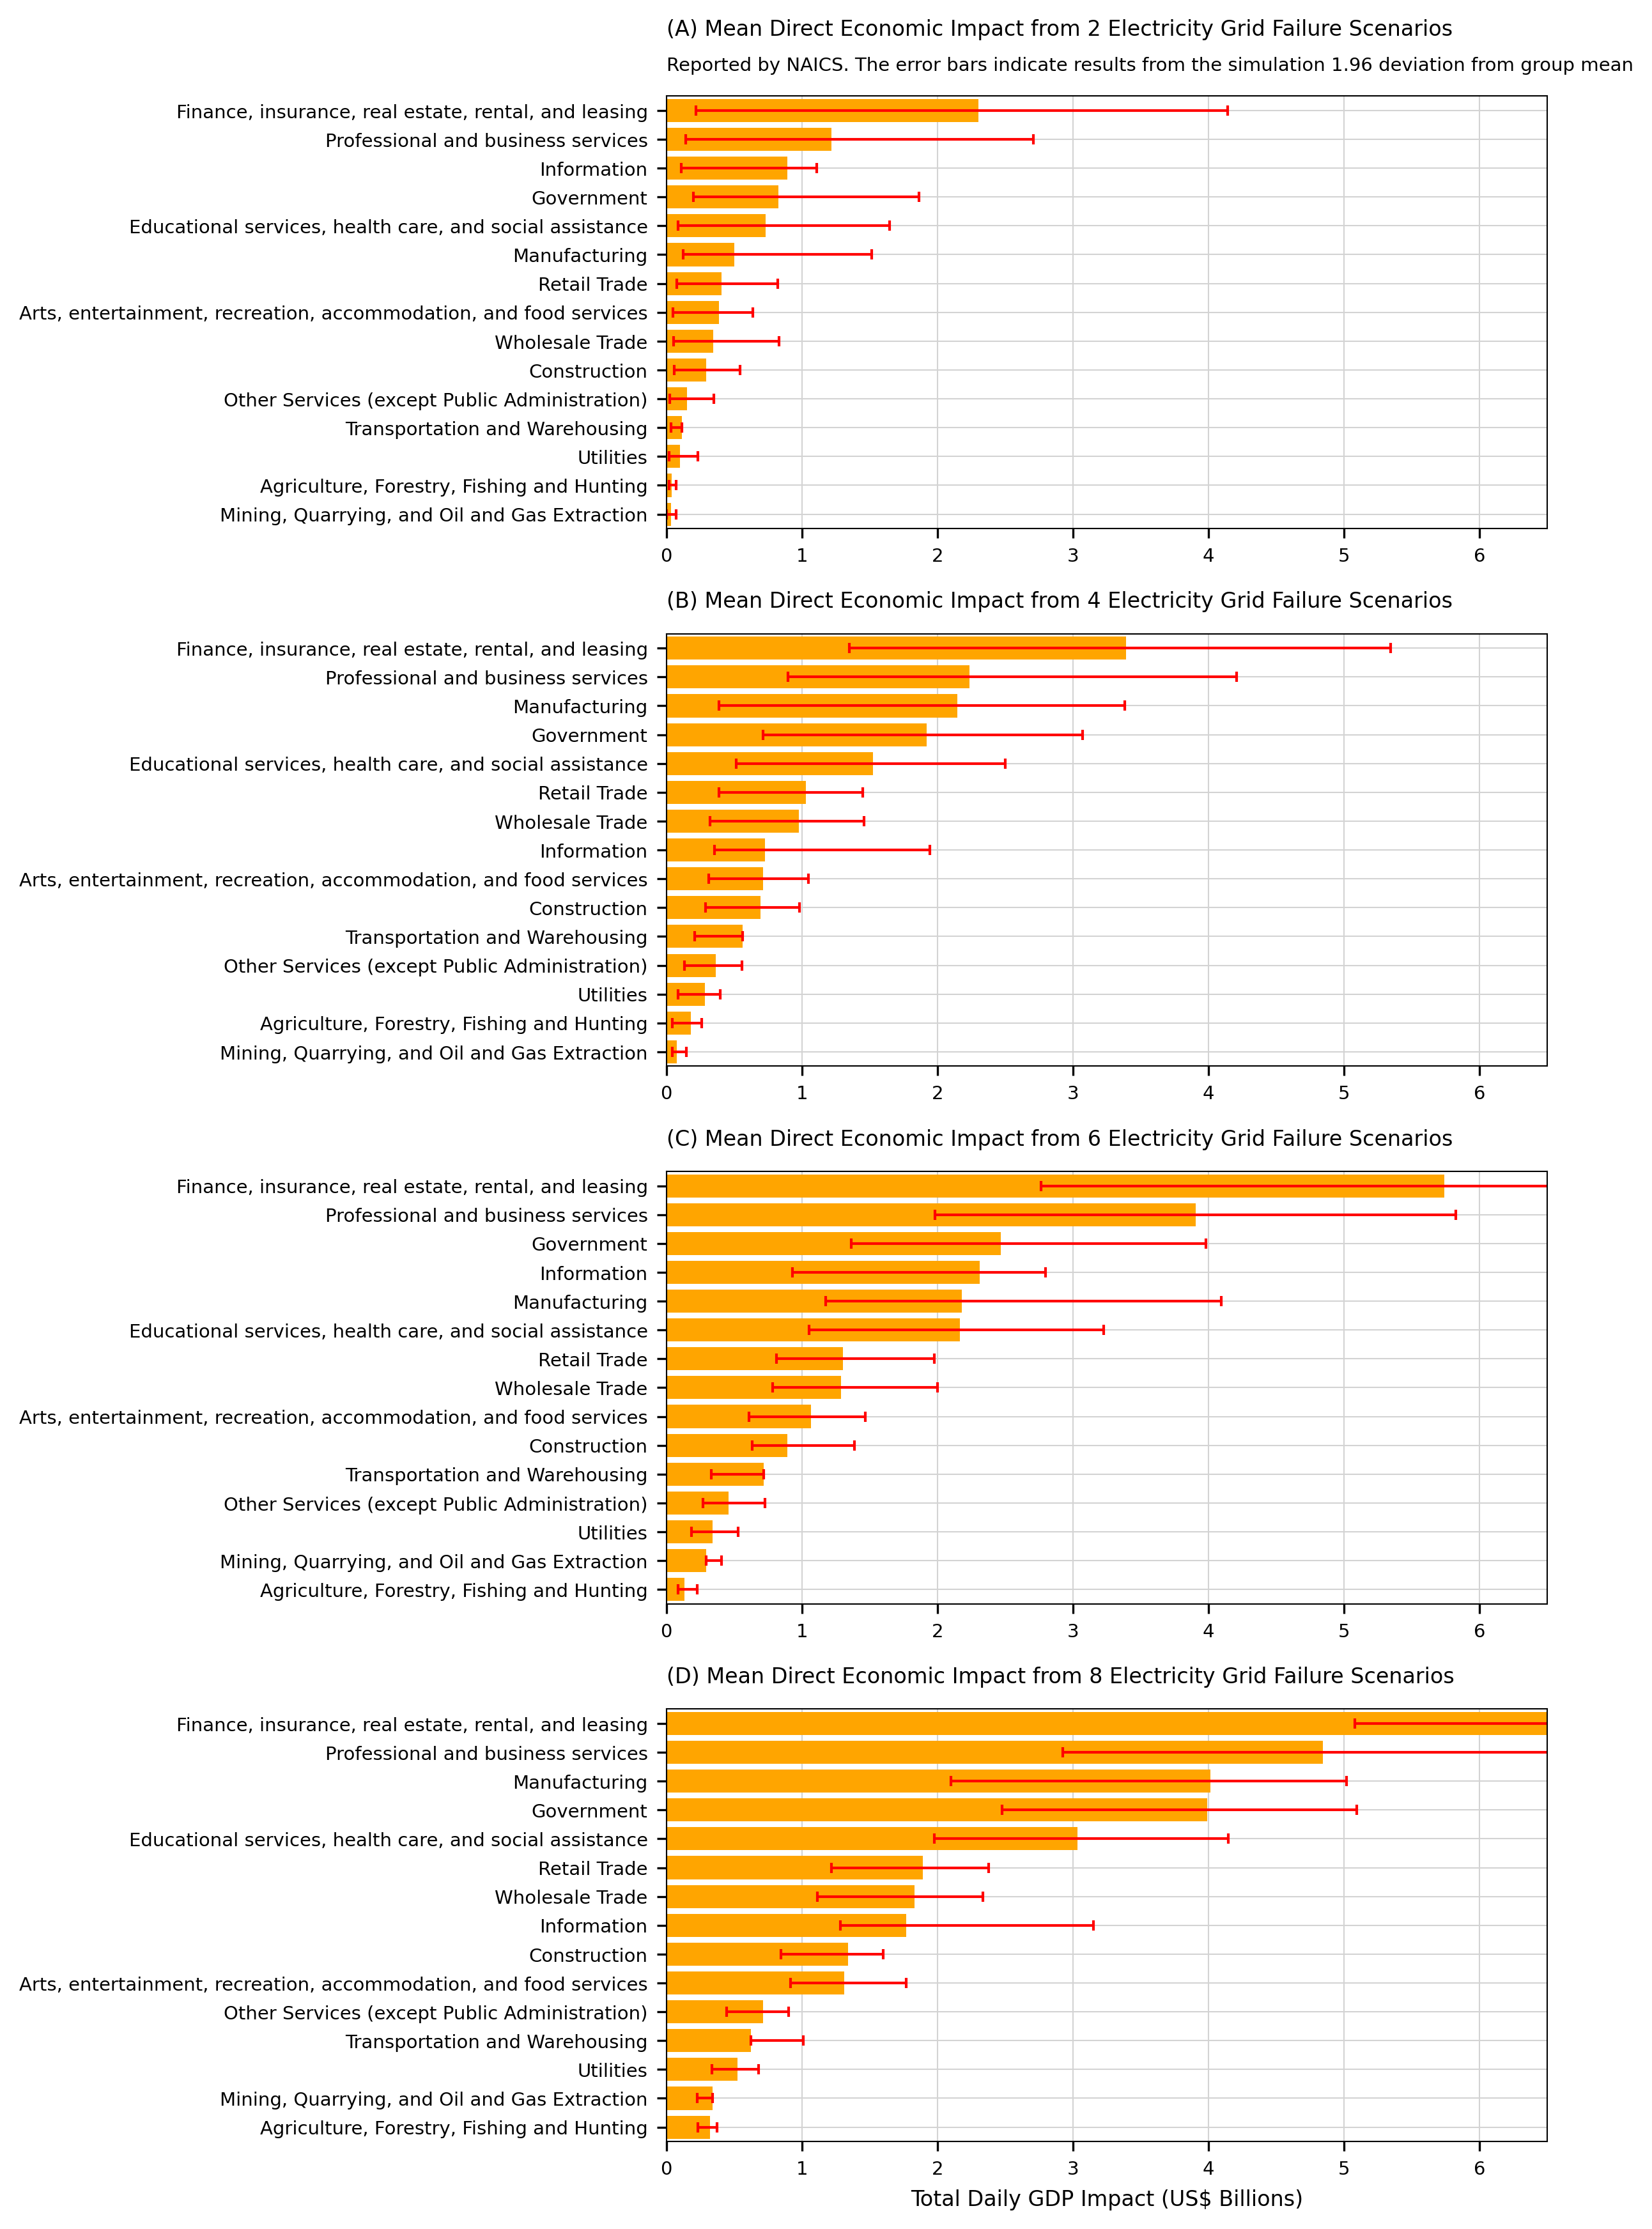

In [ ]:
# Determine the number of subplots needed
num_plots = len(grid_failures)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_plots, figsize=(8.27, 11.69), dpi=300)

# Check if there's only one plot to avoid indexing error
if num_plots == 1:
    axes = [axes]

# Import English alphabetical letters
letters = string.ascii_uppercase

# Loop though each grid failure scenario
for index, (grid_num, ax) in enumerate(zip(grid_failures, axes)):
    # Filter the DataFrame for mean, lower, and upper bounds for each grid failure Scenario
    mean_df = df[(df['Count'] == grid_num) & (df['Variable'] == 'Mean')].reset_index(drop=True)
    lower_df = df[(df['Count'] == grid_num) & (df['Variable'] == '-1.96sd')].reset_index(drop=True)
    upper_df = df[(df['Count'] == grid_num) & (df['Variable'] == '1.96sd')].reset_index(drop=True)

    # Sort mean_df in ascending order by 'Direct' values
    mean_df_sorted = mean_df.sort_values(by='Direct', ascending=True)

    # Reorder lower_df and upper_df to match the sorted order of mean_df
    lower_df_sorted = lower_df.reindex(mean_df_sorted.index)
    upper_df_sorted = upper_df.reindex(mean_df_sorted.index)

    # Horizontal bar chart for 'Direct' for mean values after sorting
    ax.barh(mean_df_sorted['NAICSIndustries'], mean_df_sorted['Direct'], label='Direct', color='orange')

    # Calculate lower and upper errors separately and set negative values to zero
    xerr_lower = np.clip(mean_df_sorted['Direct'] - lower_df_sorted['Direct'], 0, None)
    xerr_upper = np.clip(upper_df_sorted['Direct'] - mean_df_sorted['Direct'], 0, None)
    xerr = [xerr_lower, xerr_upper]

    # Error bars for precomputed lower and upper bounds
    ax.errorbar(mean_df_sorted['Direct'], mean_df_sorted['NAICSIndustries'], xerr=xerr, fmt='none',
                ecolor='red', elinewidth=1, capsize=2, capthick=1)

    # Add a subtitle in the first plot giving more information about the error bars
    if index == 0:
      ax.text(0.0, 1.13, f"({letters[index]}) Mean Direct Economic Impact from {grid_failures[index]} Electricity Grid Failure Scenarios", transform=ax.transAxes, ha='left', va='bottom', fontsize=8)
      ax.text(0.0, 1.05, f"Reported by NAICS. The error bars indicate results from the simulation 1.96 deviation from group mean", transform=ax.transAxes, ha='left', va='bottom', fontsize=7)
    else:
      # Use text as a title
      ax.text(0.0, 1.05, f"({letters[index]}) Mean Direct Economic Impact from {grid_failures[index]} Electricity Grid Failure Scenarios", transform=ax.transAxes, ha='left', va='bottom', fontsize=8)

    # If it's the last subplot, set the x-axis label
    if index == len(grid_failures) - 1:
        ax.set_xlabel('Total Daily GDP Impact (US$ Billions)', fontsize=8)

    # # Add a label on the left center outside of each plot
    # ax.text(1.1, 0.5, f'{grid_failures[index]} Grid \n Failures', transform=ax.transAxes,
    #         va='center', ha='right', fontsize=8)

    ax.set_ylim(-0.5, len(mean_df_sorted['NAICSIndustries']) - 0.5)

    ax.yaxis.set_tick_params(labelsize=7) # Adjust y-axis tick label
    ax.xaxis.set_tick_params(labelsize=7)  # Adjust x-axis tick label

    ax.set_xlim(0, 6.5)  # Sets the x-axis range from 0 to 6
    ax.grid(True, linestyle='-', linewidth=0.5, color='lightgrey') # Grid
    ax.set_axisbelow(True)  # Ensures grid lines are placed behind

    # Adjust the thickness of the bounding box
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set to a thinner line


# Get handles and labels for the legend from one of the subplots
handles, labels = axes[0].get_legend_handles_labels()


# Adjust layout for better readability
plt.tight_layout()

# Show the entire plot
plt.show()

# fig.savefig(os.path.join(working_dir, "direct.png"),
#             bbox_inches='tight')

## Include Supply Impacts

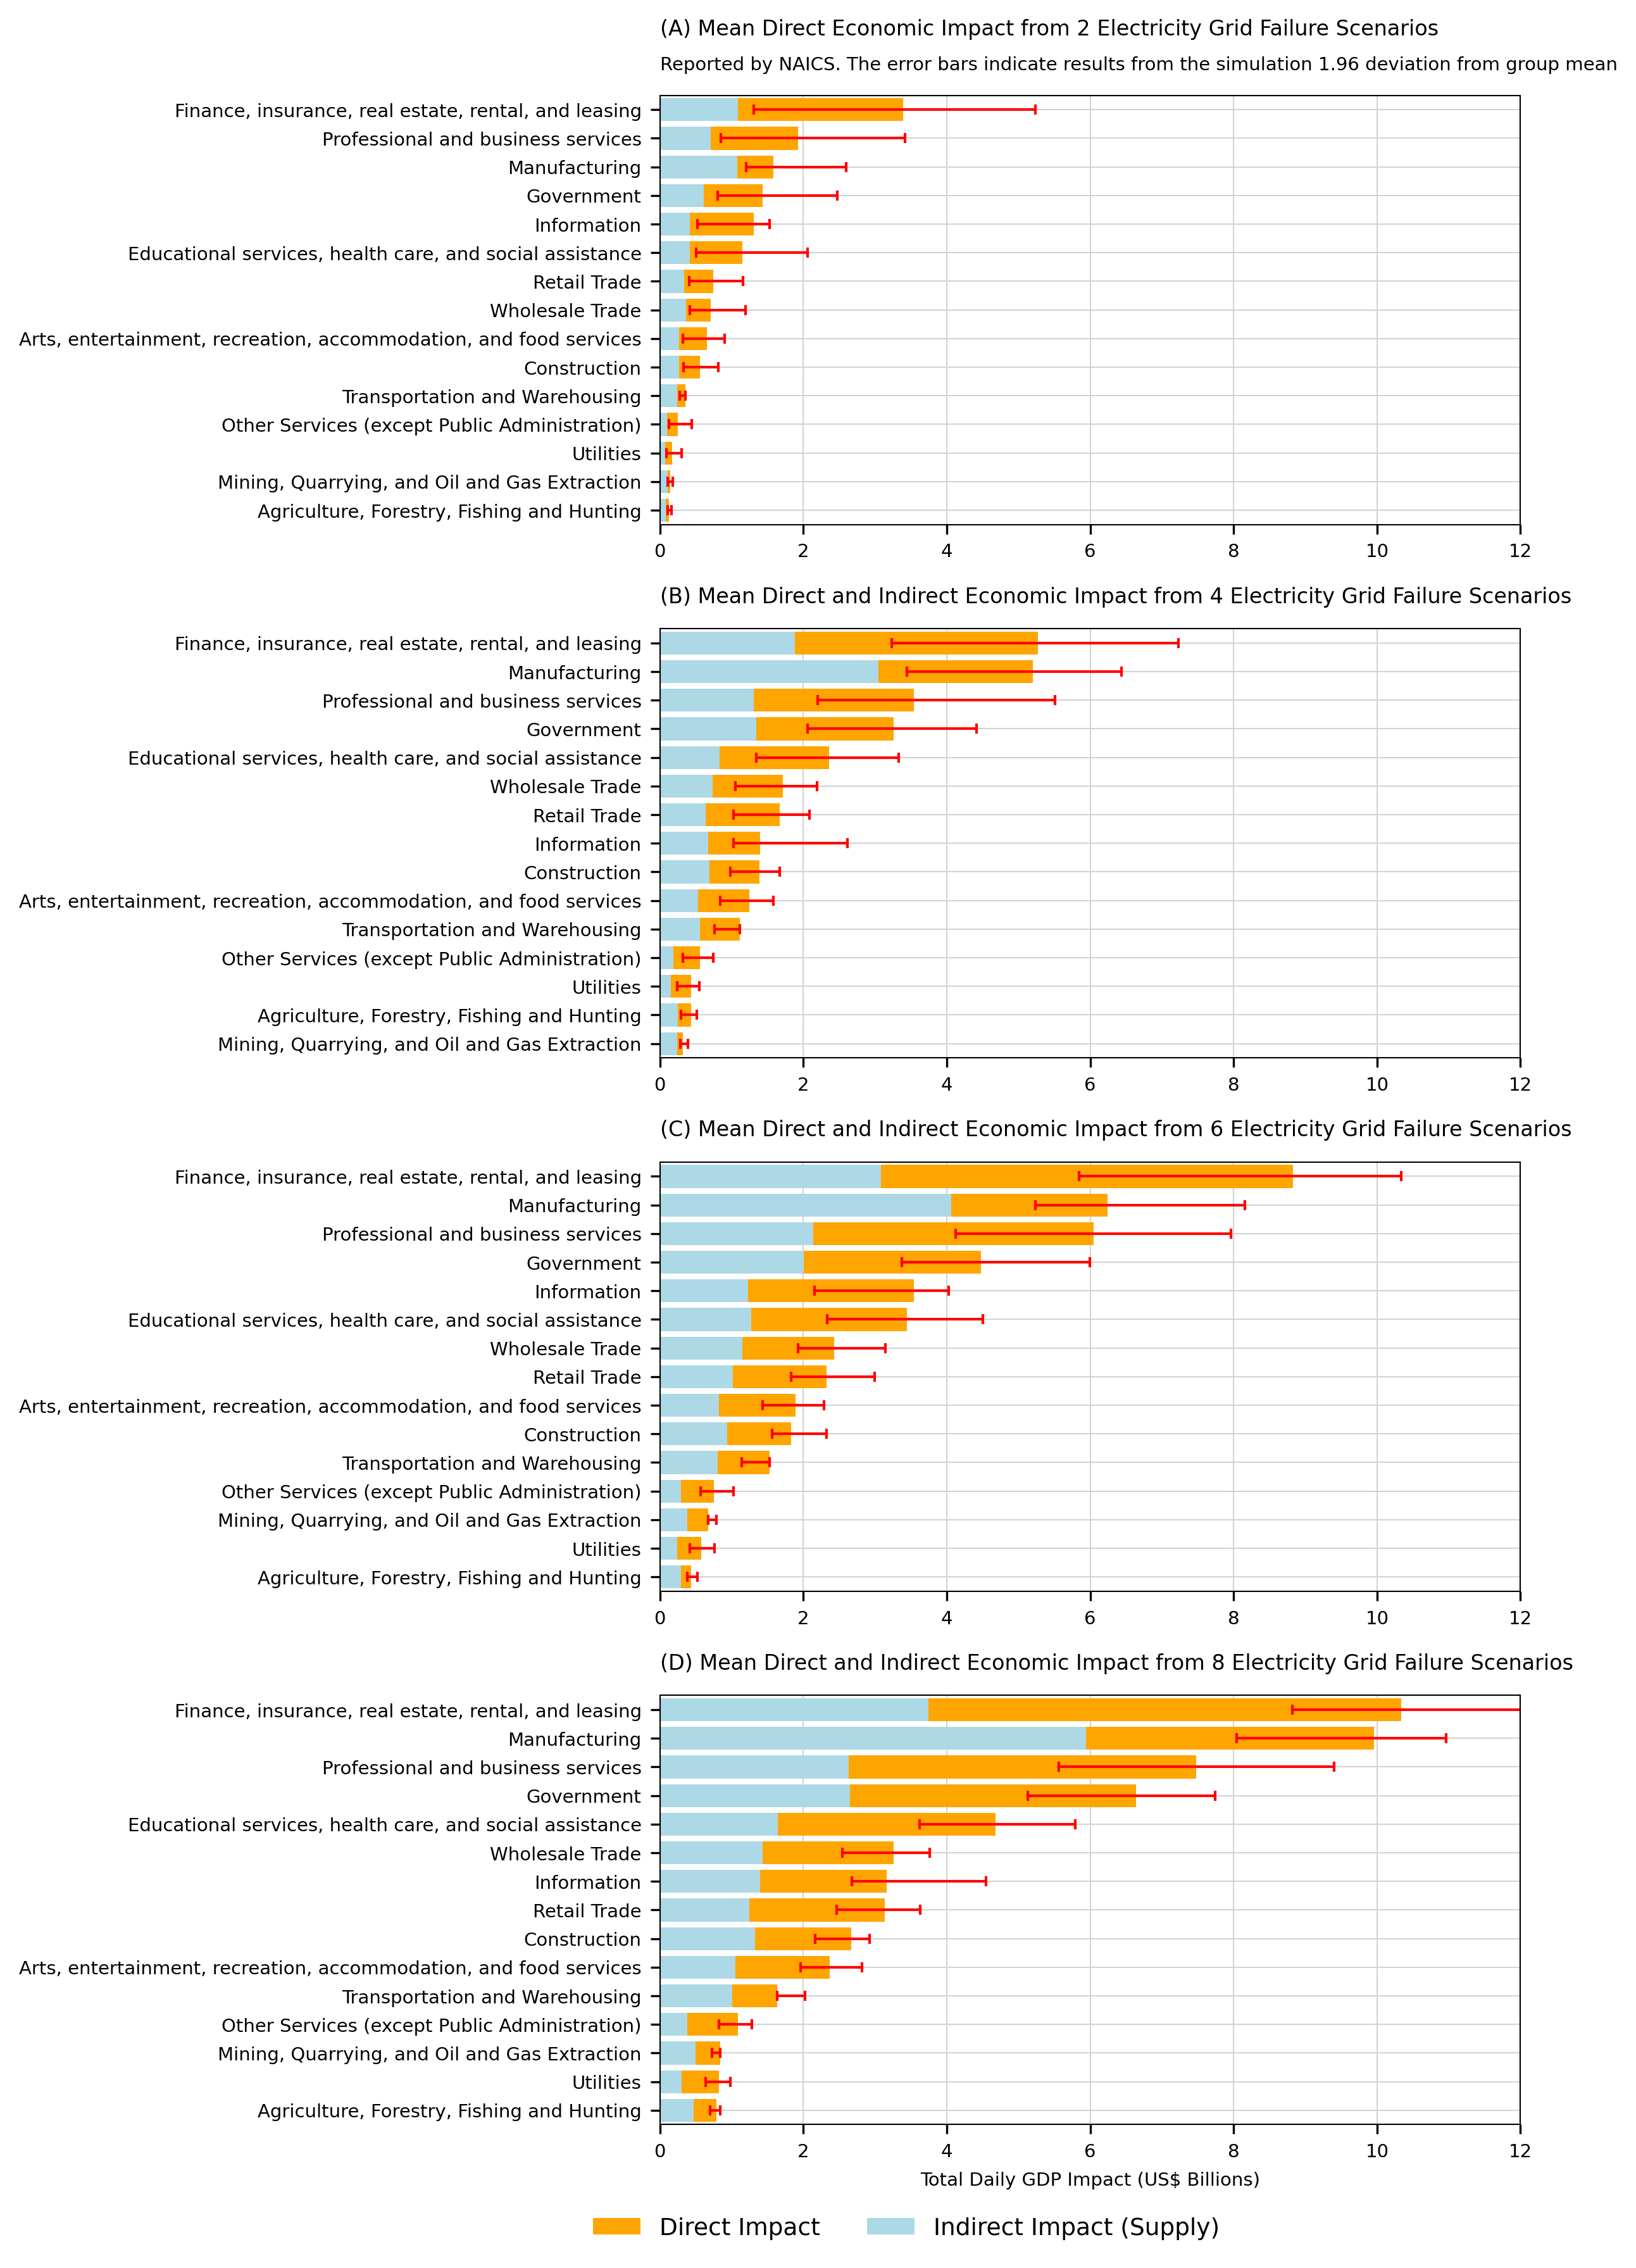

In [ ]:
# Determine the number of subplots needed
num_plots = len(grid_failures)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_plots, figsize=(8.27, 11.69), dpi=300)

# Check if there's only one plot to avoid indexing error
if num_plots == 1:
    axes = [axes]

for index, (grid_num, ax) in enumerate(zip(grid_failures, axes)):
    # Filter the DataFrame for mean, lower, and upper bounds for each grid failure Scenario
    mean_df = df[(df['Count'] == grid_num) & (df['Variable'] == 'Mean')].reset_index(drop=True)
    lower_df = df[(df['Count'] == grid_num) & (df['Variable'] == '-1.96sd')].reset_index(drop=True)
    upper_df = df[(df['Count'] == grid_num) & (df['Variable'] == '1.96sd')].reset_index(drop=True)

    # Sort mean_df in ascending order by 'Direct' values
    mean_df_sorted = mean_df.sort_values(by='Total', ascending=True)

    # Reorder lower_df and upper_df to match the sorted order of mean_df
    lower_df_sorted = lower_df.reindex(mean_df_sorted.index)
    upper_df_sorted = upper_df.reindex(mean_df_sorted.index)

    # Horizontal stacked bar chart for 'Downstream' and 'Direct'
    ax.barh(mean_df_sorted['NAICSIndustries'], mean_df_sorted['Downstream'], label='Indirect Impact (Supply)', color='lightblue')
    ax.barh(mean_df_sorted['NAICSIndustries'], mean_df_sorted['Direct'], left=mean_df_sorted['Downstream'], label='Direct Impact', color='orange')

    # Calculate lower and upper errors for 'Direct' and set negative values to zero
    xerr_lower = np.clip(mean_df_sorted['Direct'] - lower_df_sorted['Direct'], 0, None)
    xerr_upper = np.clip(upper_df_sorted['Direct'] - mean_df_sorted['Direct'], 0, None)
    xerr = [xerr_lower, xerr_upper]

    # Error bars for the 'Direct' values
    ax.errorbar(mean_df_sorted['Downstream'] + mean_df_sorted['Direct'], mean_df_sorted['NAICSIndustries'], xerr=xerr, fmt="none",
                 ecolor='red', elinewidth=1, capsize=2, capthick=1)

    # Add a subtitle in the first plot giving more information about the error bars
    if index == 0:
      ax.text(0.0, 1.13, f"({letters[index]}) Mean Direct Economic Impact from {grid_failures[index]} Electricity Grid Failure Scenarios", transform=ax.transAxes, ha='left', va='bottom', fontsize=8)
      ax.text(0.0, 1.05, f"Reported by NAICS. The error bars indicate results from the simulation 1.96 deviation from group mean", transform=ax.transAxes, ha='left', va='bottom', fontsize=7)
    else:
      # Use text as a title
      ax.text(0.0, 1.05, f"({letters[index]}) Mean Direct and Indirect Economic Impact from {grid_failures[index]} Electricity Grid Failure Scenarios", transform=ax.transAxes, ha='left', va='bottom', fontsize=8)

    # If it's the last subplot, set the x-axis label
    if index == len(grid_failures) - 1:
        ax.set_xlabel('Total Daily GDP Impact (US$ Billions)', fontsize=7)

    ax.set_ylim(-0.5, len(mean_df_sorted['NAICSIndustries']) - 0.5)

    ax.yaxis.set_tick_params(labelsize=7) # Adjust y-axis tick label
    ax.xaxis.set_tick_params(labelsize=7)  # Adjust x-axis tick label

    ax.set_xlim(0, 12)  # Sets the x-axis range from 0 to 6
    ax.grid(True, linestyle='-', linewidth=0.5, color='lightgrey') # Grid
    ax.set_axisbelow(True)  # Ensures grid lines are placed behind

    # Adjust the thickness of the bounding box
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set to a thinner line

# Retrieve handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Reorder the handles and labels
handles[0], handles[1] = handles[1], handles[0]
labels[0], labels[1] = labels[1], labels[0]

# Create a legend on the figure withg reordered labels
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.37, 0.01), ncol=4, frameon=False, fontsize=9)

# Adjust layout for better readability
plt.tight_layout()

# Show the entire plot
plt.show()

# fig.savefig(os.path.join(working_dir, "direct_indirect_plots.png"),
#             bbox_inches='tight')

## **Using Oughton 2017**

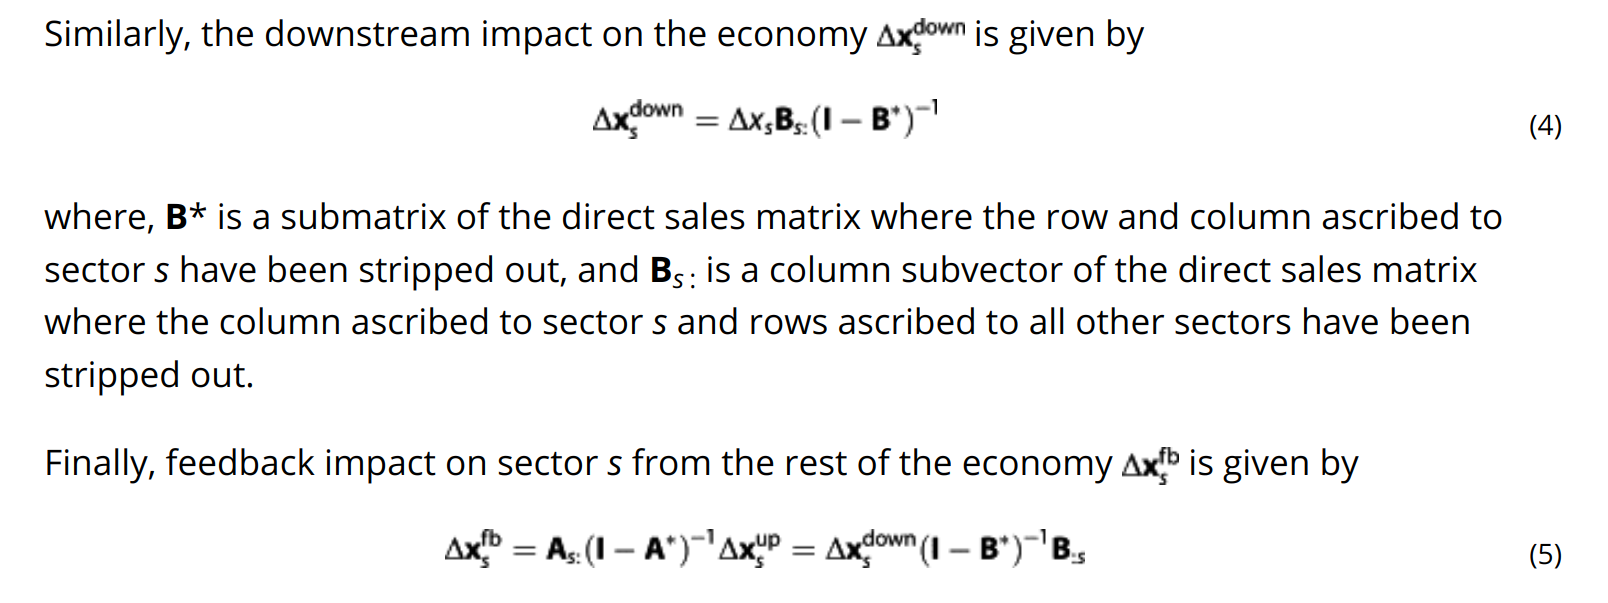

In [ ]:
def io_model(GDPShocks, scenario) -> pd.DataFrame:

  # Define the lists to collect results
  results = {
      "naics": [],
      "mean_ups": [],
      "up_pos_1SDs": [],
      "up_neg_1SDs": [],
      "mean_down": [],
      "down_pos_1SDs": [],
      "down_neg_1SDs": []
  }

  # Iterate through GDP shocks, assuming GDPShocks is defined elsewhere
  for s, (naics_code, shock_values) in enumerate(GDPShocks.iterrows()):
      # Direct shock values
      mean_direct, direct_pos_1SD, direct_neg_1SD = shock_values[["Mean", "1.96sd", "-1.96sd"]]

      # Compute A* and A_s.
      A_star = np.delete(np.delete(A, s, axis=0), s, axis=1)
      A_s = np.delete(A[:, s], s)

      # Inverse term calculation
      inverse_term = np.linalg.inv(np.eye(A_star.shape[0]) - A_star)

      # Upstream impacts
      results["mean_ups"].append(inverse_term @ A_s * mean_direct)
      results["up_pos_1SDs"].append(inverse_term @ A_s * direct_pos_1SD)
      results["up_neg_1SDs"].append(inverse_term @ A_s * direct_neg_1SD)

      # Downstream impacts / Ghosh model
      B_star = np.delete(np.delete(B, s, axis=0), s, axis=1)
      B_s = np.delete(B[:, s], s)

      results["mean_down"].append(mean_direct * B_s @ np.linalg.inv(np.eye(B_star.shape[0]) - B_star))
      results["down_pos_1SDs"].append(direct_pos_1SD * B_s @ np.linalg.inv(np.eye(B_star.shape[0]) - B_star))
      results["down_neg_1SDs"].append(direct_neg_1SD * B_s @ np.linalg.inv(np.eye(B_star.shape[0]) - B_star))

      results["naics"].append(naics_code)

  # Prepare dataframes for direct, upstream, and downstream
  data_bounds = ['Mean', '1.96sd', '-1.96sd']

  # Adding 'Type' and 'NAICSIndustries' to the direct DataFrame
  df_direct = GDPShocks.copy()
  df_direct["Type"] = "Direct"
  df_direct['NAICSIndustries'] = NAICSIndustries.values()

  # Preparing the DataFrame for upstream impacts
  df_up = pd.DataFrame({
      'Mean': np.sum(results["mean_ups"], axis=1),
      '1.96sd': np.sum(results["up_pos_1SDs"], axis=1),
      '-1.96sd': np.sum(results["up_neg_1SDs"], axis=1),
      'Type': "Upstream",
      'NAICSIndustries': NAICSIndustries.values()
  }) #

  # Preparing the DataFrame for downstream impacts
  df_down = pd.DataFrame({
      'Mean': np.sum(results["mean_down"], axis=1),
      '1.96sd': np.sum(results["down_pos_1SDs"], axis=1),
      '-1.96sd': np.sum(results["down_neg_1SDs"], axis=1),
      'Type': "Downstream",
      'NAICSIndustries': NAICSIndustries.values()
  })

  # Concatenating all the DataFrames
  df_all = pd.concat([df_direct, df_up, df_down], ignore_index=True)
  df_all["Scenario"] = scenario

  # Melting to long format
  df_long = df_all.melt(id_vars=['Type', 'NAICSIndustries', 'Scenario'], value_vars=data_bounds,
                        var_name='Variable', value_name='Output')

  df_long

  return df_long


In [ ]:
# Run Ghosh model to get indirect supply impacts
impact_dfs = []
percentile = 100
scenario_counter = 0  # Scenario counter

# Create a sorting key based on NAICSIndustries keys
sort_key = {code: i for i, code in enumerate(NAICSIndustries.keys())}

for i, scenario_df in tqdm.tqdm(enumerate(scenario_percentile_dfs)):
  extent = grid_failures[i]

  soc_econ_df = get_transformed_data(scenario_df)
  GDPShocks = soc_econ_df["gdp_by_naics"] # GDP by NAICS
  # Sort GDPShocks index based on the sort_key
  GDPShocks = GDPShocks.loc[sorted(GDPShocks.index, key=lambda x: sort_key.get(x, float('inf')))]

  concat_df = io_model(
      GDPShocks, extent
  )

  impact_dfs.append(concat_df)

impact_df = pd.concat(impact_dfs)
impact_df_reset = impact_df.groupby(["Scenario", "Type", "NAICSIndustries", "Variable"])["Output"].sum().reset_index()
impact_df_reset

4it [00:00, 15.08it/s]


,Scenario,Type,NAICSIndustries,Variable,Output
0,2,Direct,"Agriculture, Forestry, Fishing and Hunting",-1.96sd,0.021507
1,2,Direct,"Agriculture, Forestry, Fishing and Hunting",1.96sd,0.072900
2,2,Direct,"Agriculture, Forestry, Fishing and Hunting",Mean,0.039074
3,2,Direct,"Arts, entertainment, recreation, accommodation...",-1.96sd,0.050457
4,2,Direct,"Arts, entertainment, recreation, accommodation...",1.96sd,0.637607
...,...,...,...,...,...
535,8,Upstream,Utilities,1.96sd,0.360878
536,8,Upstream,Utilities,Mean,0.277760
537,8,Upstream,Wholesale Trade,-1.96sd,0.790644
538,8,Upstream,Wholesale Trade,1.96sd,1.655919


In [ ]:
# Pivot the DataFrame so that each 'Type' becomes a column
pivot_df = impact_df_reset.pivot_table(index=['Scenario', 'Variable', "NAICSIndustries"], columns='Type', values='Output', aggfunc='sum')

# Calculate the 'Total' column as the sum of 'Direct' and 'Supply' columns
pivot_df['Total'] = pivot_df.sum(axis=1)

# Reset the index to flatten the DataFrame after pivoting
pivot_df_reset = pivot_df.reset_index()

# Optionally, rename the columns to remove the multi-level column indexing
pivot_df_reset.columns.name = None  # Remove the categorization name
# pivot_df_reset.columns = ['Scenario', 'Variable', 'NAICSIndustries', 'Direct', 'Supply', 'Total']  # Explicitly name the columns

df = pivot_df_reset.copy()
df.head(5)

,Scenario,Variable,NAICSIndustries,Direct,Downstream,Upstream,Total
0,2,-1.96sd,"Agriculture, Forestry, Fishing and Hunting",0.021507,0.003163,0.013136,0.037806
1,2,-1.96sd,"Arts, entertainment, recreation, accommodation...",0.050457,0.026331,0.036148,0.112936
2,2,-1.96sd,Construction,0.058686,0.032256,0.055352,0.146293
3,2,-1.96sd,"Educational services, health care, and social ...",0.087710,0.055270,0.056997,0.199977
4,2,-1.96sd,"Finance, insurance, real estate, rental, and l...",0.219711,0.190251,0.055926,0.465888


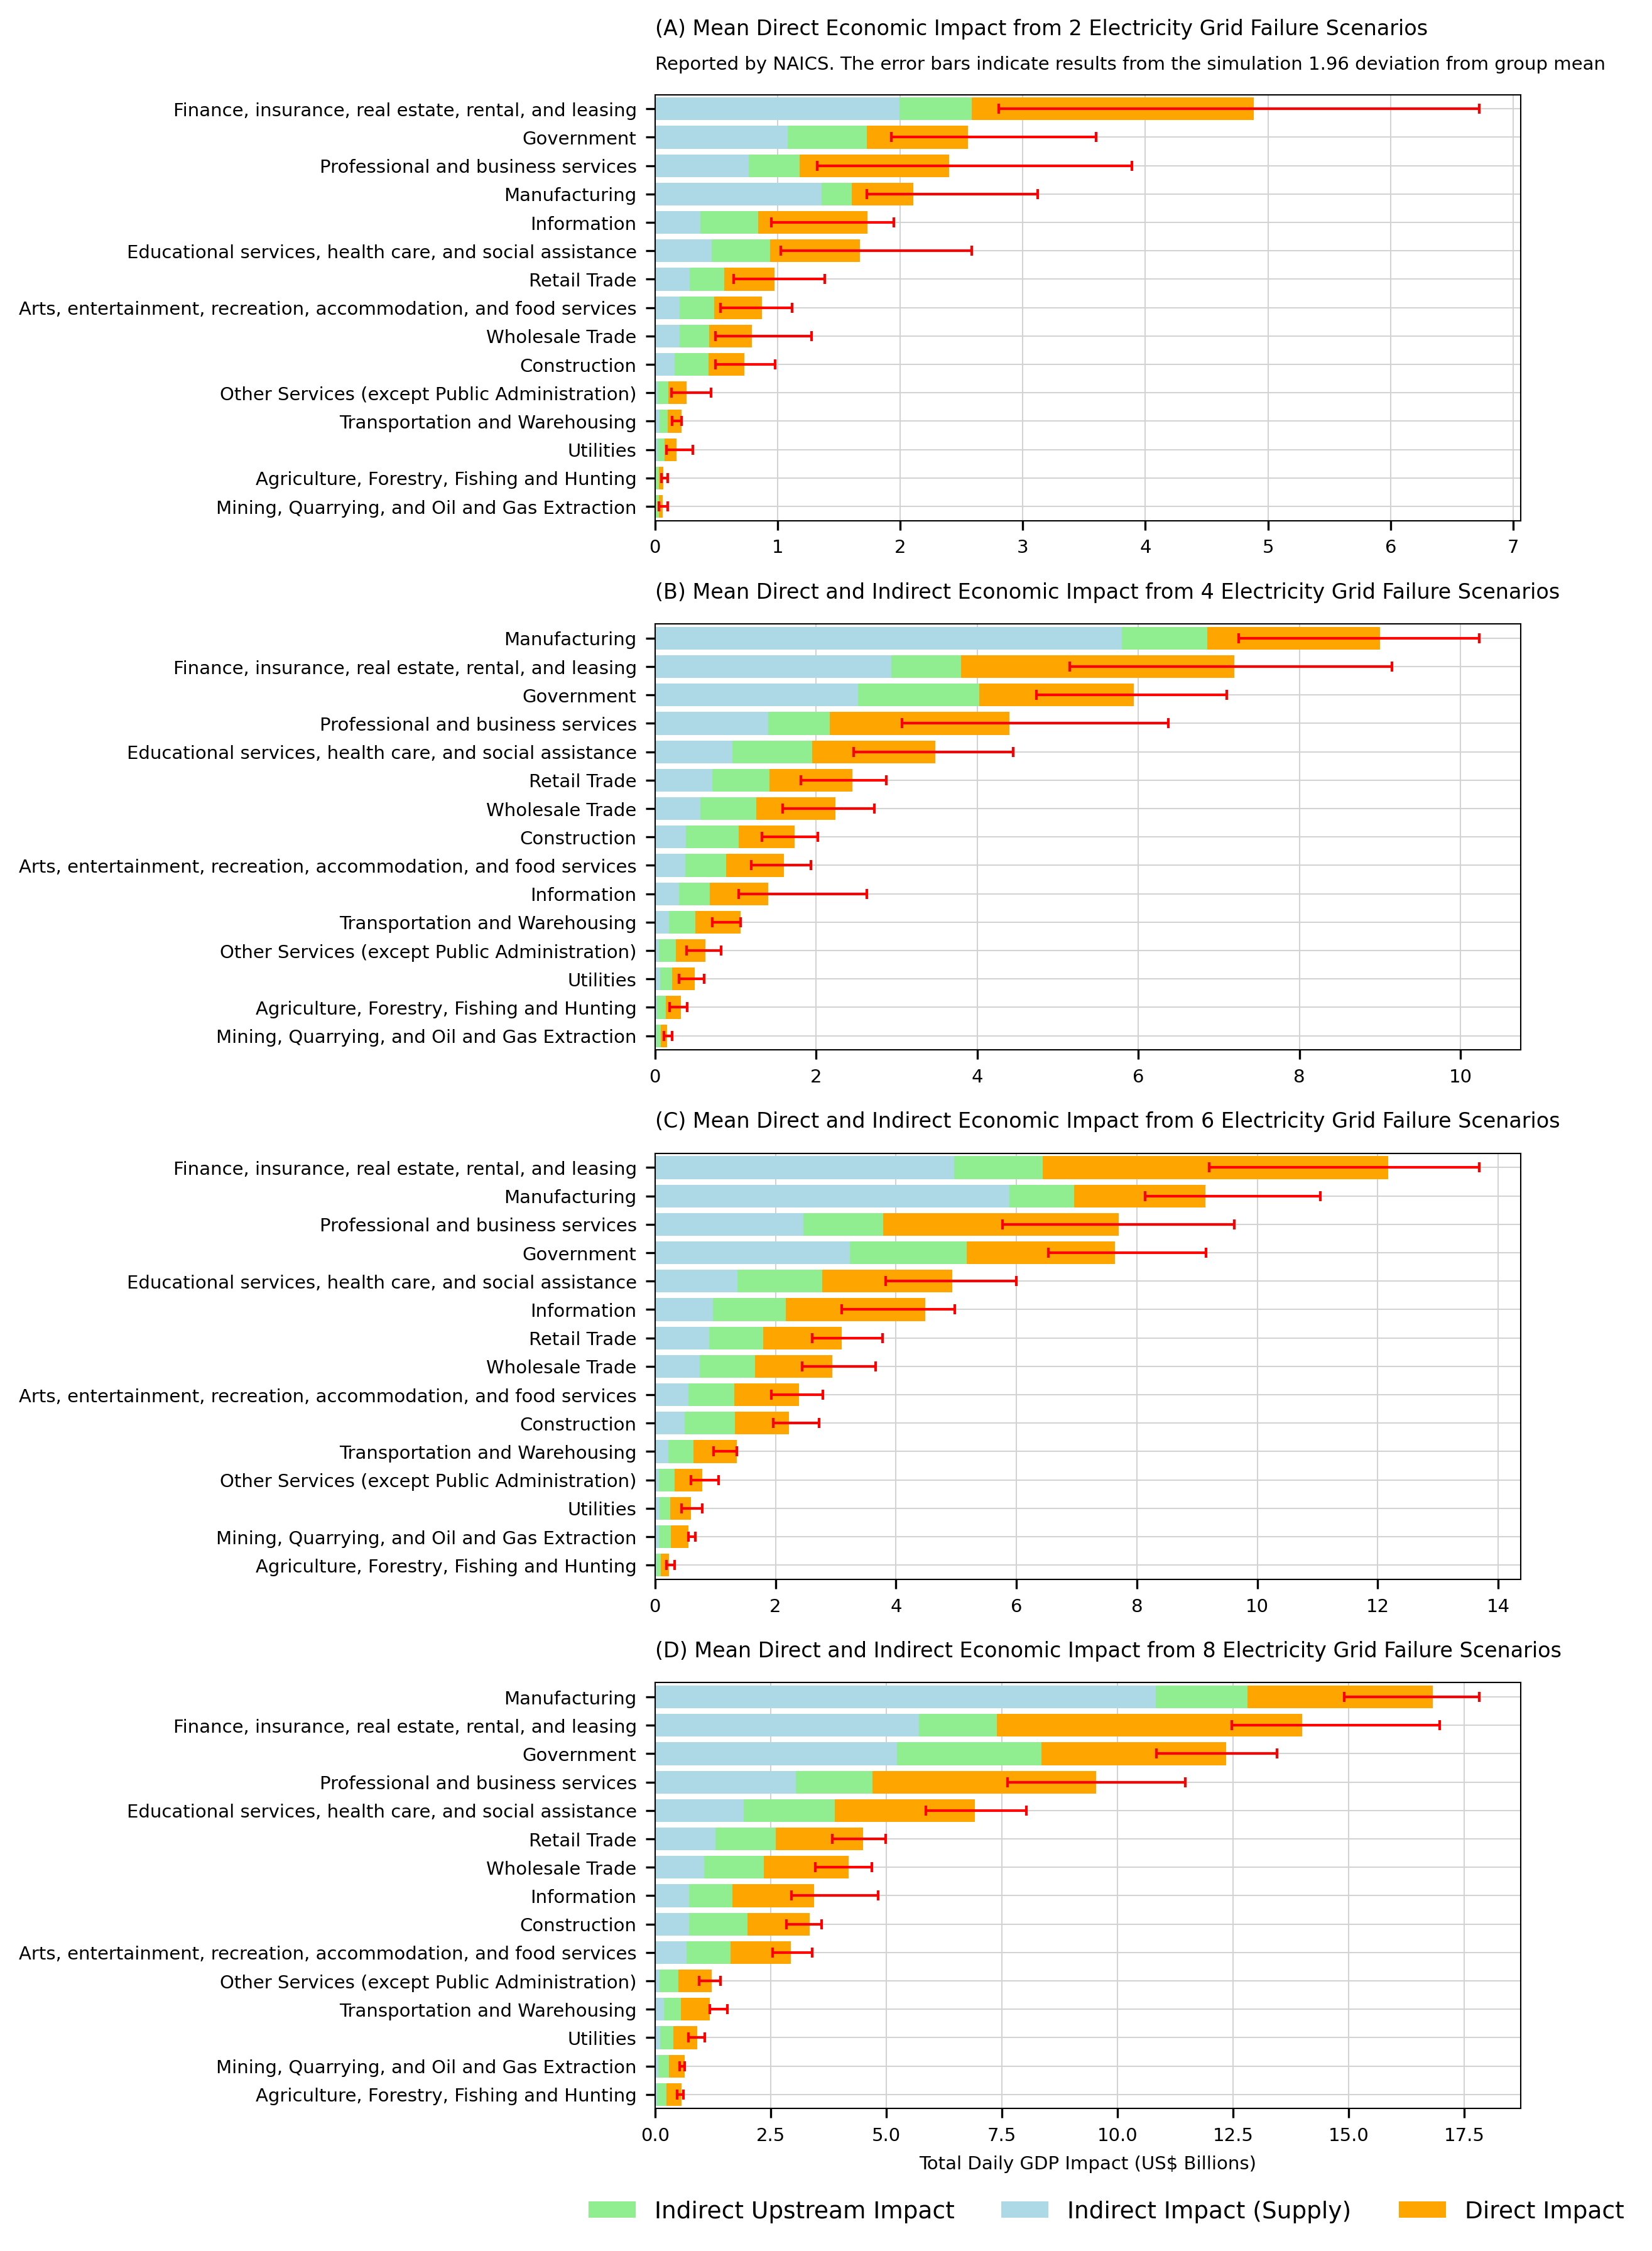

In [ ]:
# Determine the number of subplots needed
num_plots = len(grid_failures)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=num_plots, figsize=(8.27, 11.69), dpi=300)

# Check if there's only one plot to avoid indexing error
if num_plots == 1:
    axes = [axes]

for index, (grid_num, ax) in enumerate(zip(grid_failures, axes)):
    # Filter the DataFrame for mean, lower, and upper bounds for each grid failure Scenario
    mean_df = df[(df['Scenario'] == grid_num) & (df['Variable'] == 'Mean')].reset_index(drop=True)
    lower_df = df[(df['Scenario'] == grid_num) & (df['Variable'] == '-1.96sd')].reset_index(drop=True)
    upper_df = df[(df['Scenario'] == grid_num) & (df['Variable'] == '1.96sd')].reset_index(drop=True)

    # Sort mean_df in ascending order by 'Direct' values
    mean_df_sorted = mean_df.sort_values(by='Total', ascending=True)

    # Reorder lower_df and upper_df to match the sorted order of mean_df
    lower_df_sorted = lower_df.reindex(mean_df_sorted.index)
    upper_df_sorted = upper_df.reindex(mean_df_sorted.index)

    # Calculate total for 'Direct' and 'Downstream' to position 'Direct' on top
    total_direct_downstream = mean_df_sorted['Downstream'] + mean_df_sorted['Direct']

    # Horizontal stacked bar chart for 'Downstream'
    ax.barh(mean_df_sorted['NAICSIndustries'], mean_df_sorted['Downstream'], label='Indirect Impact (Supply)', color='lightblue')

    # Adding the 'Upstream' impact as a bar
    left_for_upstream = mean_df_sorted['Downstream']
    ax.barh(mean_df_sorted['NAICSIndustries'], mean_df_sorted['Upstream'], left=left_for_upstream, label='Indirect Upstream Impact', color='lightgreen')

    # Horizontal bar chart for 'Direct', positioned on top
    ax.barh(mean_df_sorted['NAICSIndustries'], mean_df_sorted['Direct'], left=mean_df_sorted['Downstream'] + mean_df_sorted['Upstream'], label='Direct Impact', color='orange')

    # Calculate lower and upper errors for 'Direct' and adjust for negative values
    xerr_lower = np.clip(mean_df_sorted['Direct'] - lower_df_sorted['Direct'], 0, None)
    xerr_upper = np.clip(upper_df_sorted['Direct'] - mean_df_sorted['Direct'], 0, None)
    xerr = [xerr_lower, xerr_upper]

    # Error bars for 'Direct', positioned correctly to reflect the 'Direct' values on top
    ax.errorbar(total_direct_downstream + mean_df_sorted['Upstream'], mean_df_sorted['NAICSIndustries'], xerr=xerr, fmt="none",
                ecolor='red', elinewidth=1, capsize=2, capthick=1)

    # Add a subtitle in the first plot giving more information about the error bars
    if index == 0:
      ax.text(0.0, 1.13, f"({letters[index]}) Mean Direct Economic Impact from {grid_failures[index]} Electricity Grid Failure Scenarios", transform=ax.transAxes, ha='left', va='bottom', fontsize=8)
      ax.text(0.0, 1.05, f"Reported by NAICS. The error bars indicate results from the simulation 1.96 deviation from group mean", transform=ax.transAxes, ha='left', va='bottom', fontsize=7)
    else:
      # Use text as a title
      ax.text(0.0, 1.05, f"({letters[index]}) Mean Direct and Indirect Economic Impact from {grid_failures[index]} Electricity Grid Failure Scenarios", transform=ax.transAxes, ha='left', va='bottom', fontsize=8)

    # If it's the last subplot, set the x-axis label
    if index == len(grid_failures) - 1:
        ax.set_xlabel('Total Daily GDP Impact (US$ Billions)', fontsize=7)

    ax.set_ylim(-0.5, len(mean_df_sorted['NAICSIndustries']) - 0.5)

    ax.yaxis.set_tick_params(labelsize=7) # Adjust y-axis tick label
    ax.xaxis.set_tick_params(labelsize=7)  # Adjust x-axis tick label

    # ax.set_xlim(0, 12)  # Sets the x-axis range from 0 to 6
    ax.grid(True, linestyle='-', linewidth=0.5, color='lightgrey') # Grid
    ax.set_axisbelow(True)  # Ensures grid lines are placed behind

    # Adjust the thickness of the bounding box
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)  # Set to a thinner line

# Retrieve handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Reorder the handles and labels
handles[0], handles[1] = handles[1], handles[0]
labels[0], labels[1] = labels[1], labels[0]

# Create a legend on the figure withg reordered labels
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.37, 0.01), ncol=4, frameon=False, fontsize=9)

# Adjust layout for better readability
plt.tight_layout()

# Show the entire plot
plt.show()

# fig.savefig(os.path.join(working_dir, "direct_indirect_plots.png"),
#             bbox_inches='tight')